# Proyecto Cancer Bucal EfficientNetB0

## Librerias

In [1]:
##Librerias
import cv2
import os
import shutil
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Conv2D, Flatten, MaxPool2D, Dropout
from keras.models import Sequential
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

## Contar Imagenes Procesadas

In [2]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
       #Conteo de numero de imagenes dentro de las Carpetas
        num_of_image[folder] = len(os.listdir(os.path.join(path, folder)));
    return num_of_image;

path = r'C:\Users\enavarro\Desktop\Tesis MGTT\Entrenamientos\Codigos\DataSet\Dataset_Tesis\Data Procesada Kaagle';
DatasetSize = GetDatasetSize(path);
print(DatasetSize);

{'cancer': 437, 'non-cancer': 437}


## División de Datos 

# Entrenamiento Xception

In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import tensorflow as tf
import random
import matplotlib.pyplot as plt

# Semillas para reproducibilidad
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# Función para cargar imágenes
def load_images(image_paths, image_size):
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=image_size)
        img_array = img_to_array(img) / 255.0
        images.append(img_array)
    return np.array(images)

# Crear modelo EfficientNetB0 con fine-tuning
def crea_modelo_EfficientNetB0():
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    for layer in base_model.layers[:-50]:  # Congelar más capas
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Regularización L2
    x = Dropout(0.6)(x)  # Aumentar dropout
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    optimizer = Adam(learning_rate=0.00005)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    )
    return model

# Configuración
root_dir = r'C:\Users\enavarro\Desktop\Tesis MGTT\Entrenamientos\Codigos\DataSet\Dataset_Tesis\Data Procesada Kaagle'
classes_dir = ['cancer', 'non-cancer']
n_splits = 5
image_size = (256, 256)

# Leer imágenes y etiquetas
image_paths = []
labels = []
for cls in classes_dir:
    cls_dir = os.path.join(root_dir, cls)
    for img_name in os.listdir(cls_dir):
        image_paths.append(os.path.join(cls_dir, img_name))
        labels.append(0 if cls == 'non-cancer' else 1)

image_paths, labels = shuffle(np.array(image_paths), np.array(labels), random_state=SEED)

# Configuración de validación cruzada
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

fold_results = []
training_histories = []
roc_data = []

for fold, (train_index, val_index) in enumerate(kf.split(image_paths, labels), start=1):
    print(f"Entrenando en el pliegue {fold}/{n_splits}...")

    train_paths, val_paths = image_paths[train_index], image_paths[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    # Cargar imágenes en memoria
    train_images = load_images(train_paths, image_size)
    val_images = load_images(val_paths, image_size)

    # Generador de aumentación de datos
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    train_datagen = datagen.flow(train_images, train_labels, batch_size=16)

    # Calcular pesos de las clases
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights = dict(enumerate(class_weights))

    # Crear modelo
    model = crea_modelo_EfficientNetB0()

    # Callbacks
    checkpoint_callback = ModelCheckpoint(
        filepath=f"best_model_fold{fold}.keras",
        monitor="val_auc",
        save_best_only=True,
        verbose=1
    )
    early_stopping_callback = EarlyStopping(
        monitor="val_auc",
        patience=5,
        verbose=1,
        restore_best_weights=True
    )
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )

    # Entrenamiento
    history = model.fit(
        train_datagen,
        steps_per_epoch=len(train_images) // 16,
        epochs=25,
        validation_data=(val_images, val_labels),
        class_weight=class_weights,
        callbacks=[checkpoint_callback, early_stopping_callback, lr_scheduler]
    )

    # Guardar historial
    training_histories.append(history.history)

    # Generar predicciones en el conjunto de validación
    val_predictions = model.predict(val_images)
    val_predictions_binary = (val_predictions > 0.5).astype(int)

    # Calcular F1-score
    f1 = f1_score(val_labels, val_predictions_binary)
    print(f"F1-score en el pliegue {fold}: {f1}")

    # Calcular valores para la curva ROC
    fpr, tpr, thresholds = roc_curve(val_labels, val_predictions)
    roc_auc = auc(fpr, tpr)

    # Guardar datos ROC
    roc_data.append({'fold': fold, 'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc})

    # Evaluación
    val_metrics = model.evaluate(val_images, val_labels)
    val_auc = val_metrics[2]
    val_precision = val_metrics[3]
    val_recall = val_metrics[4]
    fold_results.append({
        'fold': fold,
        'val_loss': val_metrics[0],
        'val_accuracy': val_metrics[1],
        'val_auc': val_auc,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    })




Entrenando en el pliegue 1/5...
Epoch 1/25
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.4955 - auc: 0.4756 - loss: 11.8684 - precision: 0.5064 - recall: 0.5949
Epoch 1: val_auc improved from inf to 0.50000, saving model to best_model_fold1.keras
43/43 ━━━━━━━━━━━━━━━━━━━━ 65s 879ms/step - accuracy: 0.4954 - auc: 0.4758 - loss: 11.8635 - precision: 0.5061 - recall: 0.5934 - val_accuracy: 0.4971 - val_auc: 0.5000 - val_loss: 11.1906 - val_precision: 0.4971 - val_recall: 1.0000 - learning_rate: 5.0000e-05
Epoch 2/25
 1/43 ━━━━━━━━━━━━━━━━━━━━ 25s 610ms/step - accuracy: 0.4375 - auc: 0.4048 - loss: 11.2573 - precision: 0.3750 - recall: 0.4286
Epoch 2: val_auc did not improve from 0.50000
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.4375 - auc: 0.4048 - loss: 11.2573 - precision: 0.3750 - recall: 0.4286 - val_accuracy: 0.4971 - val_auc: 0.5000 - val_loss: 11.1710 - val_precision: 0.4971 - val_recall: 1.0000 - learning_rate: 5.0000e-05
Epoch 3/25
43/43 ━━━━━━━━━━━━━━━━━━━

In [4]:
# Inicializar listas para almacenar métricas de entrenamiento
all_train_accuracy = []
all_train_loss = []

# Extraer métricas de cada pliegue
for history in training_histories:
    all_train_accuracy.extend(history['accuracy'])  # Extender para obtener todos los valores de todas las épocas
    all_train_loss.extend(history['loss'])

# Calcular los promedios generales
mean_train_accuracy = np.mean(all_train_accuracy)
mean_train_loss = np.mean(all_train_loss)

# Imprimir resultados generales
print("Train Accuracy General:", mean_train_accuracy)
print("Train Loss General:", mean_train_loss)




# Resultados finales
results_df = pd.DataFrame(fold_results)

print("\nResultados de validación cruzada:")
print(results_df)

print("\nPromedios de métricas:")
print(results_df.mean())

print("\nDesviaciones estándar de métricas:")
print(results_df.std())

Train Accuracy General: 0.5029501809227851
Train Loss General: 10.557677392036684

Resultados de validación cruzada:
   fold   val_loss  val_accuracy  val_auc  val_precision  val_recall  \
0     1  11.190616      0.497143      0.5       0.497143         1.0   
1     2  11.189722      0.502857      0.5       0.000000         0.0   
2     3  11.192567      0.497143      0.5       0.000000         0.0   
3     4  11.198454      0.497143      0.5       0.000000         0.0   
4     5  11.174620      0.500000      0.5       0.000000         0.0   

   f1_score   roc_auc  
0  0.664122  0.602534  
1  0.000000  0.537944  
2  0.000000  0.390739  
3  0.000000  0.439525  
4  0.000000  0.440679  

Promedios de métricas:
fold              3.000000
val_loss         11.189196
val_accuracy      0.498857
val_auc           0.500000
val_precision     0.099429
val_recall        0.200000
f1_score          0.132824
roc_auc           0.482284
dtype: float64

Desviaciones estándar de métricas:
fold           

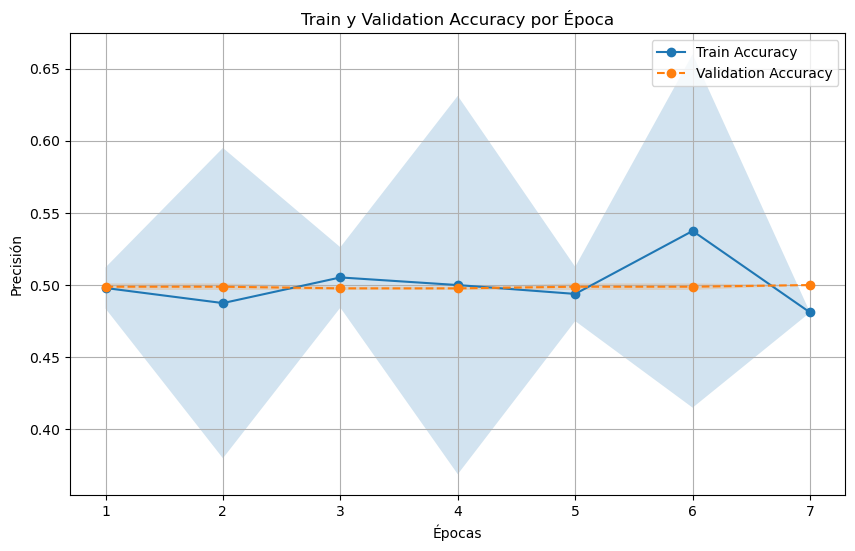

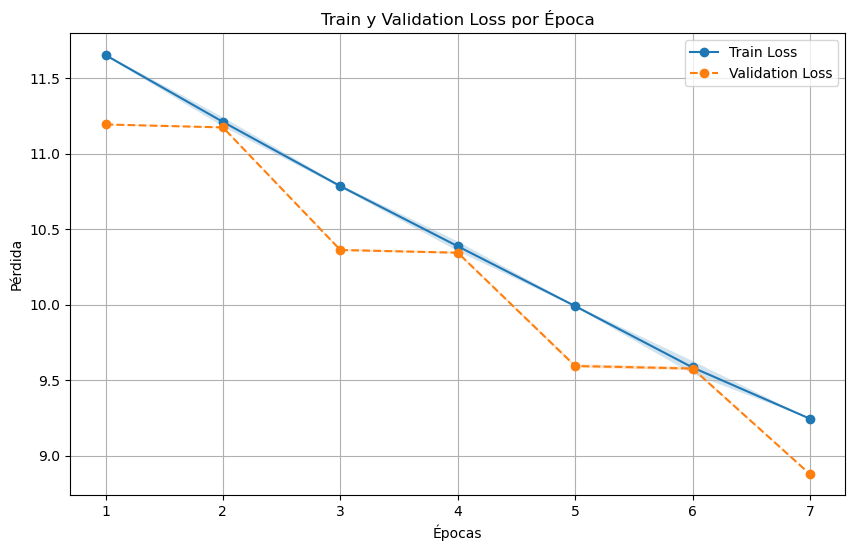

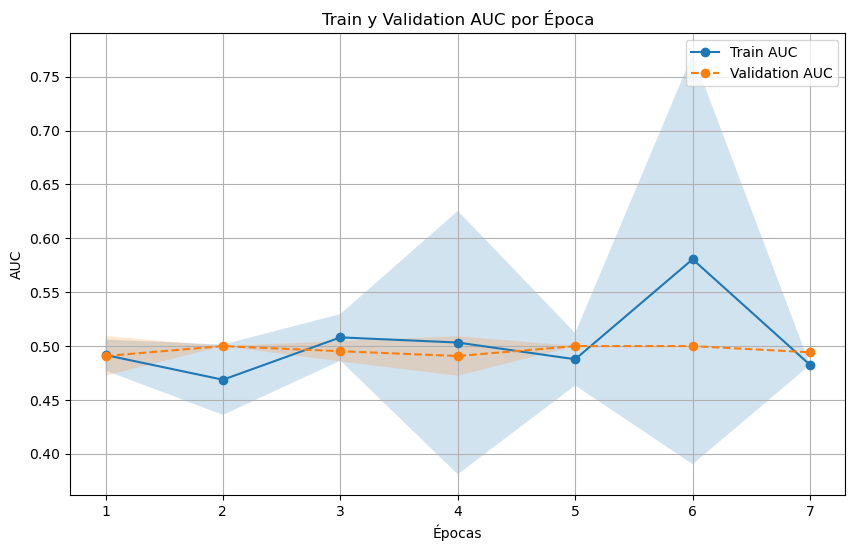

In [5]:
# Crear listas para almacenar los valores promedio y desviaciones estándar por época
mean_train_accuracy = []
std_train_accuracy = []
mean_val_accuracy = []
std_val_accuracy = []

mean_train_loss = []
std_train_loss = []
mean_val_loss = []
std_val_loss = []

mean_train_auc = []
std_train_auc = []
mean_val_auc = []
std_val_auc = []

# Determinar el número máximo de épocas entre todos los historiales
max_epochs = max([len(h['accuracy']) for h in training_histories])

# Convertir los historiales de entrenamiento a DataFrames para cálculos por época
for epoch in range(max_epochs):
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []
    train_aucs = []
    val_aucs = []

    # Recopilar métricas de cada pliegue
    for h in training_histories:
        if epoch < len(h['accuracy']):  # Solo incluir si hay datos para esta época
            train_accuracies.append(h['accuracy'][epoch])
            val_accuracies.append(h['val_accuracy'][epoch])
            train_losses.append(h['loss'][epoch])
            val_losses.append(h['val_loss'][epoch])
            train_aucs.append(h['auc'][epoch])
            val_aucs.append(h['val_auc'][epoch])

    # Calcular promedios y desviaciones estándar
    mean_train_accuracy.append(np.mean(train_accuracies))
    std_train_accuracy.append(np.std(train_accuracies))
    mean_val_accuracy.append(np.mean(val_accuracies))
    std_val_accuracy.append(np.std(val_accuracies))

    mean_train_loss.append(np.mean(train_losses))
    std_train_loss.append(np.std(train_losses))
    mean_val_loss.append(np.mean(val_losses))
    std_val_loss.append(np.std(val_losses))

    mean_train_auc.append(np.mean(train_aucs))
    std_train_auc.append(np.std(train_aucs))
    mean_val_auc.append(np.mean(val_aucs))
    std_val_auc.append(np.std(val_aucs))

# Número de épocas
epochs = np.arange(1, len(mean_train_accuracy) + 1)

# Gráfico de Train y Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, mean_train_accuracy, label="Train Accuracy", marker='o')
plt.fill_between(epochs,
                 np.array(mean_train_accuracy) - np.array(std_train_accuracy),
                 np.array(mean_train_accuracy) + np.array(std_train_accuracy), alpha=0.2)
plt.plot(epochs, mean_val_accuracy, label="Validation Accuracy", marker='o', linestyle='--')
plt.fill_between(epochs,
                 np.array(mean_val_accuracy) - np.array(std_val_accuracy),
                 np.array(mean_val_accuracy) + np.array(std_val_accuracy), alpha=0.2)
plt.title("Train y Validation Accuracy por Época")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de Train y Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, mean_train_loss, label="Train Loss", marker='o')
plt.fill_between(epochs,
                 np.array(mean_train_loss) - np.array(std_train_loss),
                 np.array(mean_train_loss) + np.array(std_train_loss), alpha=0.2)
plt.plot(epochs, mean_val_loss, label="Validation Loss", marker='o', linestyle='--')
plt.fill_between(epochs,
                 np.array(mean_val_loss) - np.array(std_val_loss),
                 np.array(mean_val_loss) + np.array(std_val_loss), alpha=0.2)
plt.title("Train y Validation Loss por Época")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)
plt.show()

# Gráfico de Train y Validation AUC
plt.figure(figsize=(10, 6))
plt.plot(epochs, mean_train_auc, label="Train AUC", marker='o')
plt.fill_between(epochs,
                 np.array(mean_train_auc) - np.array(std_train_auc),
                 np.array(mean_train_auc) + np.array(std_train_auc), alpha=0.2)
plt.plot(epochs, mean_val_auc, label="Validation AUC", marker='o', linestyle='--')
plt.fill_between(epochs,
                 np.array(mean_val_auc) - np.array(std_val_auc),
                 np.array(mean_val_auc) + np.array(std_val_auc), alpha=0.2)
plt.title("Train y Validation AUC por Época")
plt.xlabel("Épocas")
plt.ylabel("AUC")
plt.legend()
plt.grid(True)
plt.show()







# Grafico

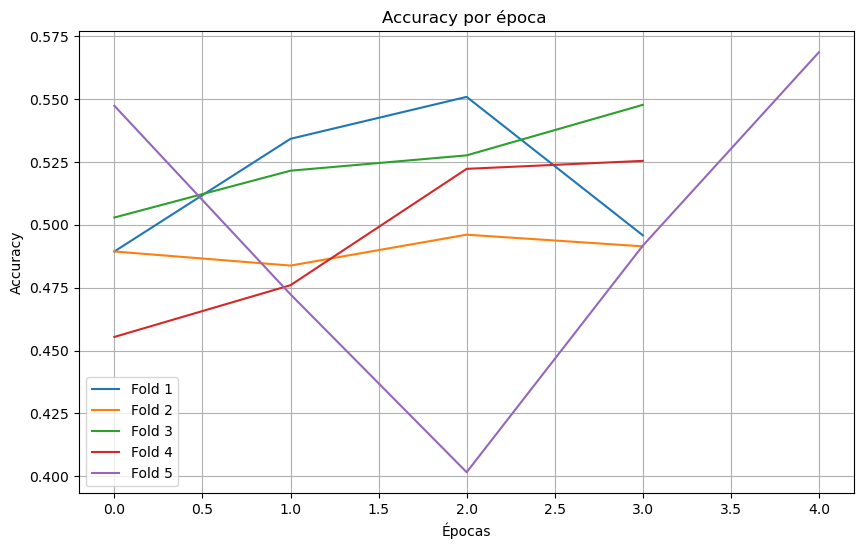

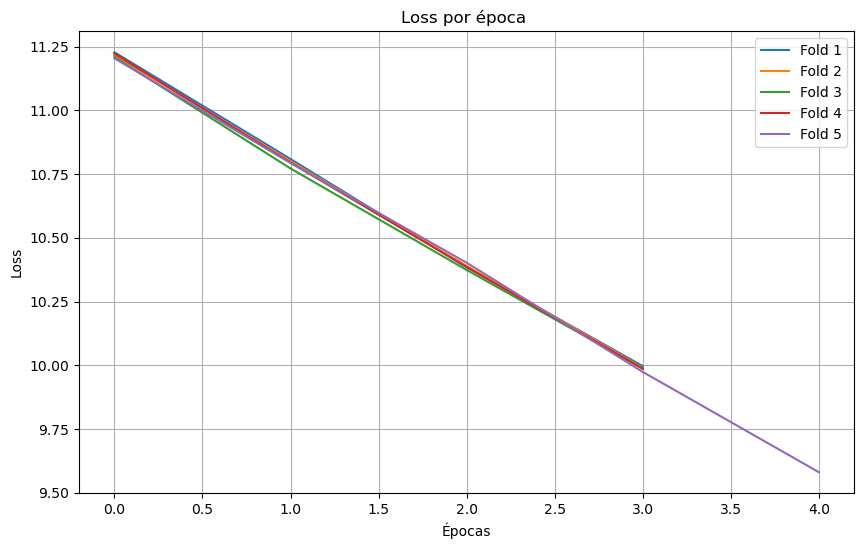

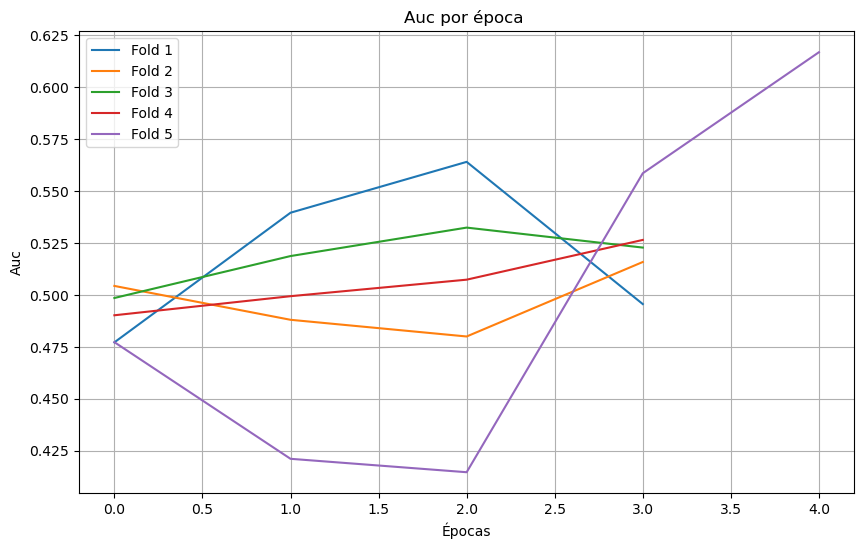

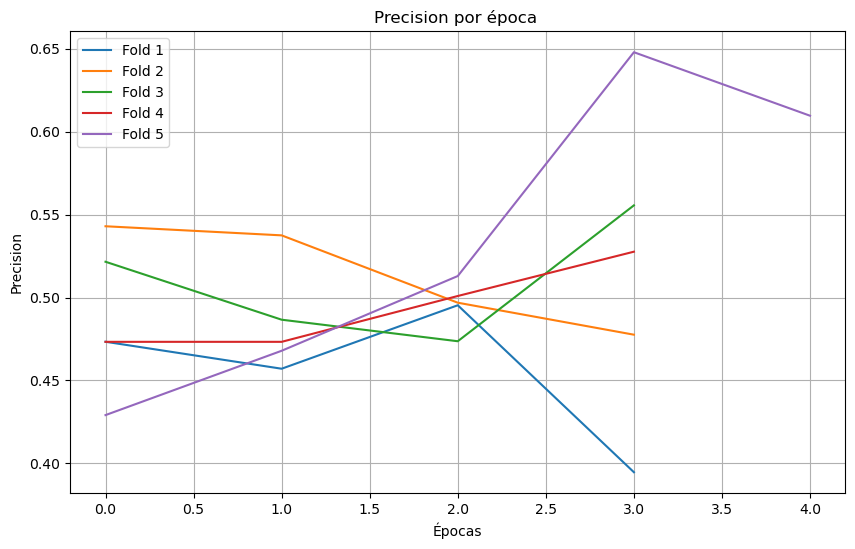

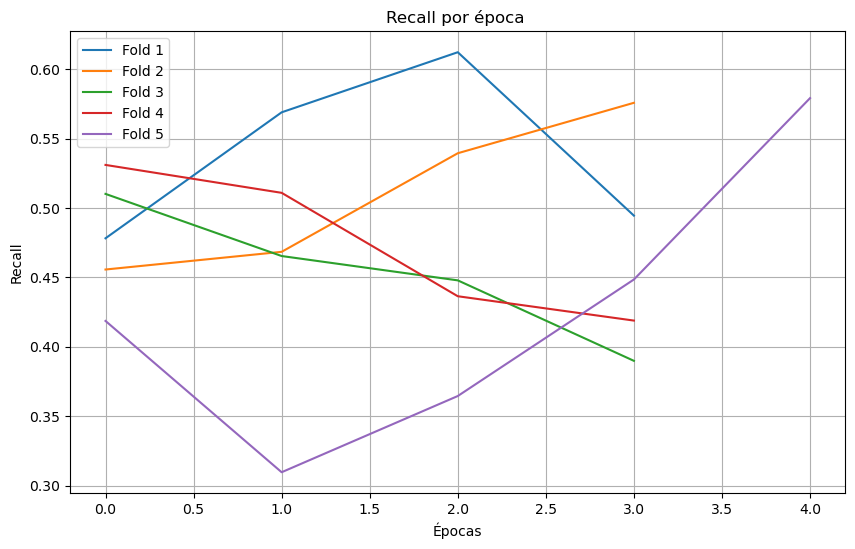

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Función para calcular el promedio móvil
def moving_average(data, window_size=3):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Graficar métricas de entrenamiento y validación suavizadas
#metrics_to_plot = ['accuracy', 'val_accuracy', 'loss', 'val_loss', 'auc', 'val_auc', 'precision', 'val_precision', 'recall', 'val_recall']
metrics_to_plot = ['accuracy', 'loss', 'auc', 'precision', 'recall']
window_size = 3  # Tamaño de la ventana para el promedio móvil

for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    for fold, history in enumerate(training_histories, start=1):
        if metric in history:
            data = history[metric]
            if len(data) > window_size:  # Aplicar suavizado solo si hay suficientes datos
                data = moving_average(data, window_size)
                epochs = np.arange(len(data))
                plt.plot(epochs, data, label=f'Fold {fold}')
            else:  # Si no hay suficientes datos, graficar tal cual
                plt.plot(history[metric], label=f'Fold {fold}')
    plt.title(f'{metric.capitalize()} por época ')
    plt.xlabel('Épocas')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()
    plt.show()


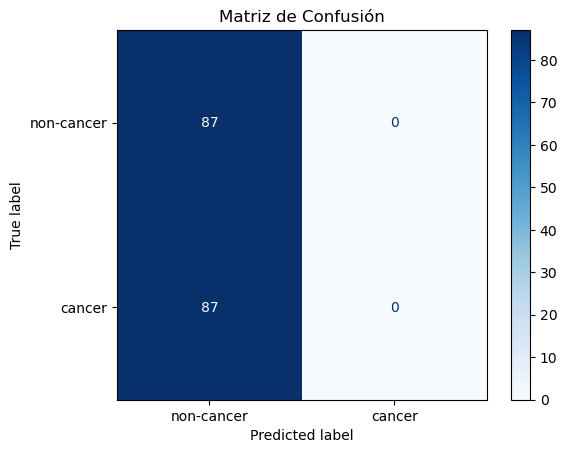

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcular la matriz de confusión
cm = confusion_matrix(val_labels, val_predictions_binary)

# Graficar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-cancer', 'cancer'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión')
plt.show()



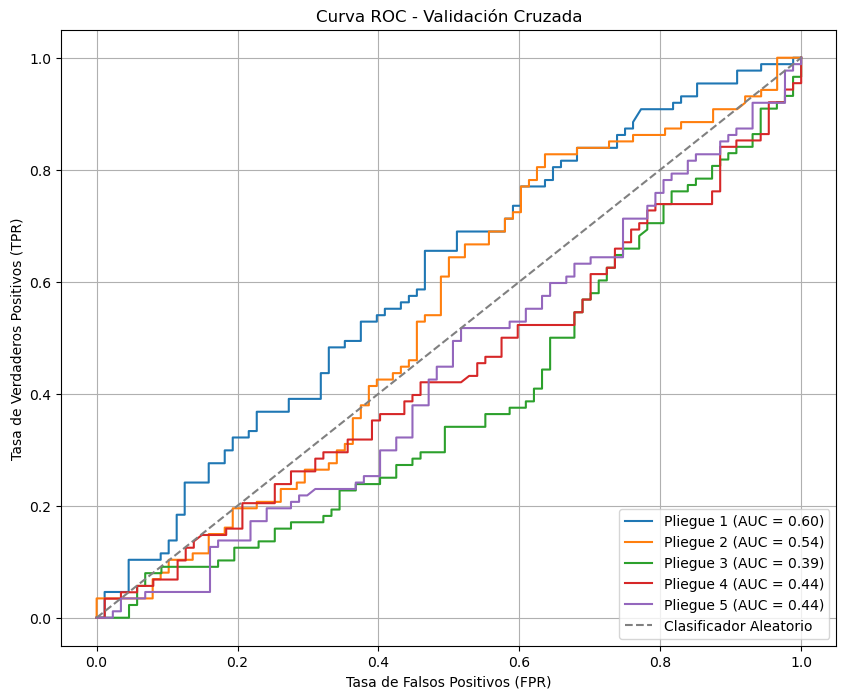

In [8]:

# Graficar curvas ROC para cada pliegue
plt.figure(figsize=(10, 8))
for data in roc_data:
    plt.plot(data['fpr'], data['tpr'], label=f"Pliegue {data['fold']} (AUC = {data['roc_auc']:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Validación Cruzada')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Exportar Modelo 

In [54]:
# Guardar Modelo Entrenado con mejor desempeño
model.save("EfficientNetB0.hdf5")